<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Tensorflow Deep learning framework
import tensorflow as tf
from tensorflow import keras 


#Data manipulation
import pandas 

#Calculation
import numpy as np


#Visualization
import matplotlib.pyplot as plt

#Paths
import pathlib
from pathlib import Path

#PIL for opening images
import PIL

In [2]:
print("Version", tf.__version__) #We are dealing with tensorflow 2

Version 2.8.0


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [4]:
#Check the size of the images downloaded 
image_count = len(list(data_dir.glob("*/*.jpg")))

In [5]:
image_count #A total of three thousand six hundred and seventy  images

3670

In [6]:
#Lets visualize a few of the images
roses = list(data_dir.glob("roses/*"))

In [7]:
first_image = PIL.Image.open(roses[0]) #We visualize the first image of the roses in the list

In [8]:
first_image.size

(180, 240)

In [9]:
batch_size = 64
image_height = 256
image_width = 256 

In [10]:
#We now load the data from the directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed =123, 
    batch_size = batch_size, 
    image_size = (image_width, image_height,)
) #Automatically loads and splits the dataset into the ration 80:20 
#80% for training and  20% for testing

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, 
    subset = "validation",
    seed = 123,
    batch_size = batch_size,
    image_size =(image_width, image_height)
) #Sets a side 20% of the data to be utilized for validation

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
#Normalize the dataset
normalize_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_data = train_dataset.map(lambda x,y: (normalize_layer(x),y)) #Turns data to be floating point numbers in between zero and one

In [14]:
#We can check the maximum value in our dataset to see  whether they are floating point numbers in between zero and one
for image_batch, labels_batch in normalized_data:
  print(np.max(image_batch[0])) #Maximum value in an individual normalized image data
  print(np.min(image_batch[0])) #Minimum value in an individual normalized image data 
  break

1.0
0.0


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 

In [16]:
num_channels = 3
image_size = (image_width,image_height, num_channels)

In [17]:
num_class = len(train_dataset.class_names)

In [18]:
num_class #5 classes in total

5

In [63]:
for image_batch, labels_batch in train_dataset:
  print(image_batch[0].shape)
  print(labels_batch.shape)
  break

(256, 256, 3)
(64,)


In [19]:
#We can now build our computational graph using the Sequential model and functional api  


model = Sequential()
normalization_layer = model.add(layers.Rescaling(1.255,input_shape=image_size))
fistConv = model.add(layers.Conv2D(16,(3,3)))
firstMaxPool = model.add(layers.MaxPooling2D((2,2)))

#Second ConvBlock 
secondConvBlock = model.add(layers.Conv2D(32,(3,3),activation='relu'))
secondMaxPooling = model.add(layers.MaxPooling2D((2,2)))

#ThirdConvBlock 
thirdConv = model.add(layers.Conv2D(64,(3,3), activation="relu"))
thirdMaxPooling = model.add(layers.MaxPooling2D((2,2)))

#Fourth ConvBlock
fourth = model.add(layers.Conv2D(128,(3,3), activation = "relu"))
fourthMaxPooling = model.add(layers.MaxPooling2D((2,2)))


#Flatten the learned features
flatten = model.add(layers.Flatten())#turns the learned features from a 2D array (matrix) into a  vector  
#Zero mean and center
batch_norm = model.add(layers.BatchNormalization()) #Reduced vanishing and exploding gradients and speeds up training  
#First dense layer
dense_300 = model.add(layers.Dense(300,kernel_initializer="he_normal")) #Dense layer of 300 neurons and a weight initialization strategy
#First activation function 
activation_func1 = model.add(layers.Activation('elu')) #Applied non-linearity to our model
#Dense layer of 100 neurons
dense_100  = model.add(layers.Dense(100,kernel_initializer="he_normal"))
activation_func2 = model.add(layers.Activation('elu'))
#Second BatchNorm
batch_norm2 = model.add(layers.BatchNormalization())
#Outputlayer 
output_layer = model.add(layers.Dense(num_class,activation="softmax"))

In [20]:
#Compile our model i.e define the hyperparameters. Parameters of the learning algorithm 
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer="Adam",metrics=['Accuracy'])

In [46]:
#Check the summary of our model before traing
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 60, 60, 64)      

In [149]:
data_augmentation = tf.keras.Sequential([
 tf.keras.layers.RandomFlip("horizontal",input_shape=(image_height, image_width,3)),
 tf.keras.layers.RandomRotation(0.1),
 tf.keras.layers.RandomZoom(0.1)
])

In [156]:
#New model
modelOne = tf.keras.models.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=image_size),
tf.keras.layers.Conv2D(16,(3,3), activation = 'relu'),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(300,kernel_initializer="he_normal"),
tf.keras.layers.Activation('elu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(100,kernel_initializer="he_normal"),
tf.keras.layers.Activation('elu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(num_class,activation='softmax')
])

In [158]:
modelOne.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='Adam',metrics =['Accuracy'])

In [ ]:
tf.keras.utils.plot_model(model)

In [67]:
#Define the checkpoint and callback function to save the model every 5 seconds and inform us when validation loss has improved
check_point = "classify_model/-cp{epoch:04d}.ckpt"
call_back = tf.keras.callbacks.ModelCheckpoint(check_point,verbose=1,save_freq=5 * batch_size, save_weights_only=True)
model.save_weights(check_point.format(epoch=0))

In [68]:
#Pass the dataset into memory for easier loading after the first epoch
AUTOTUNE = tf.data.AUTOTUNE
#train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [69]:
#Pass the validation dataset into memory
#validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [70]:
#train_dataset = train_dataset.as_numpy_iterator()

In [71]:
#validation_dataset = validation_dataset.as_numpy_iterator()

In [74]:
#Train the model 
history = model.fit(train_dataset, batch_size=batch_size, epochs= 20,verbose =1,validation_data=[validation_dataset], callbacks=call_back)

Epoch 1/20
46/46 [==============================] - 4s 89ms/step - loss: 0.0039 - Accuracy: 1.0000 - val_loss: 0.9615 - val_Accuracy: 0.6376
Epoch 2/20
46/46 [==============================] - 4s 90ms/step - loss: 0.0030 - Accuracy: 1.0000 - val_loss: 0.9740 - val_Accuracy: 0.6621
Epoch 3/20
46/46 [==============================] - 4s 90ms/step - loss: 0.0024 - Accuracy: 1.0000 - val_loss: 1.0042 - val_Accuracy: 0.6676
Epoch 4/20
41/46 [=========================>....] - ETA: 0s - loss: 0.0020 - Accuracy: 1.0000
Epoch 4: saving model to classify_model/-cp0004.ckpt
46/46 [==============================] - 4s 93ms/step - loss: 0.0021 - Accuracy: 1.0000 - val_loss: 1.0431 - val_Accuracy: 0.6744
Epoch 5/20
46/46 [==============================] - 4s 88ms/step - loss: 0.0018 - Accuracy: 1.0000 - val_loss: 1.0794 - val_Accuracy: 0.6839
Epoch 6/20
46/46 [==============================] - 4s 88ms/step - loss: 0.0015 - Accuracy: 1.0000 - val_loss: 1.1108 - val_Accuracy: 0.6785
Epoch 7/20
46/46 [

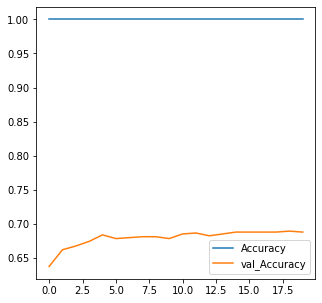

In [80]:
#Plot the perfomance of the model 
plt.figure(figsize=(5,5))
plt.plot(history.history['Accuracy'], label= 'Accuracy')
plt.plot(history.history['val_Accuracy'], label = 'val_Accuracy')
plt.legend(loc="lower right")

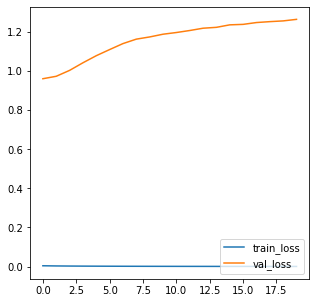

In [85]:
#Plot the loss 
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label ='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc= "lower right")

Data Augmentation with keras sequential api: Data Augmentation is recreating new data examples from existing training examples

In [104]:
dataAugmentation = tf.keras.Sequential([
#tf.keras.layers.Flatten(),
tf.keras.layers.RandomFlip("horizontal",input_shape=(256,256,3)),
tf.keras.layers.RandomRotation(0.1),
tf.keras.layers.RandomZoom(0.1)
])

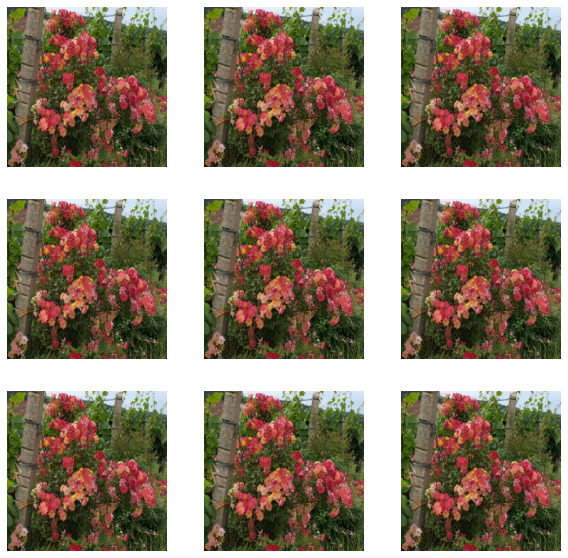

In [113]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = dataAugmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [129]:
data_augmentation = tf.keras.Sequential([
 tf.keras.layers.RandomFlip("horizontal",input_shape=(image_height, image_width,3)),
 tf.keras.layers.RandomRotation(0.1),
 tf.keras.layers.RandomZoom(0.1)
])

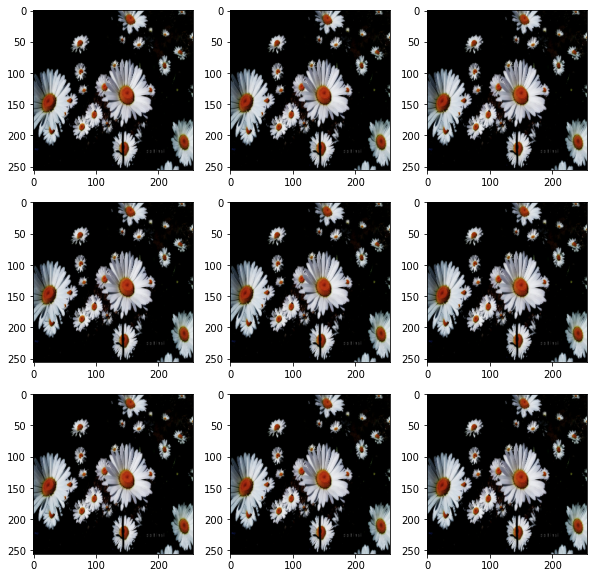

In [130]:
#Visualize the augmented images 
figure = plt.figure(figsize=(10,10))
for images,_ in train_dataset.take(1):
  for i in range(9):
    figure.add_subplot(3,3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

Applying dropout regularization(constraining our model to make it simple) which kills neurons i.e sets some neurons activations to  zero.

In [137]:
#Lets create a model with drop out regularization
model = tf.keras.models.Sequential([
data_augmentation,
tf.keras.layers.Rescaling(1./255, input_shape=(256,256,3)),
tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
tf.keras.layers.MaxPooling2D((2,2)),
tf.keras.layers.Conv2D(32,(3,3), activation ='relu'),
tf.keras.layers.MaxPool2D((2,2)),
tf.keras.layers.Conv2D(64,(3,3),activation = "relu"),
tf.keras.layers.MaxPool2D((2,2)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dense(num_class,activation="softmax") 
])

In [140]:
#Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer ="Adam",metrics=['Accuracy'])

In [142]:
AUTOTUNE  = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [143]:
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [159]:
History = modelOne.fit(train_dataset,batch_size=batch_size, epochs = 10, validation_data=[validation_dataset], callbacks=[call_back], verbose =1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 6s 96ms/step - loss: 1.4275 - Accuracy: 0.4605 - val_loss: 1.6738 - val_Accuracy: 0.3351
Epoch 2/10
46/46 [==============================] - 4s 92ms/step - loss: 1.0646 - Accuracy: 0.5708 - val_loss: 1.8067 - val_Accuracy: 0.2275
Epoch 3/10
46/46 [==============================] - 4s 92ms/step - loss: 0.9662 - Accuracy: 0.6233 - val_loss: 1.6202 - val_Accuracy: 0.2439
Epoch 4/10
46/46 [==============================] - 4s 92ms/step - loss: 0.9019 - Accuracy: 0.6461 - val_loss: 1.4511 - val_Accuracy: 0.3651
Epoch 5/10
46/46 [==============================] - 4s 92ms/step - loss: 0.8502 - Accuracy: 0.6720 - val_loss: 1.0862 - val_Accuracy: 0.5913
Epoch 6/10
13/46 [=======>......................] - ETA: 2s - loss: 0.7917 - Accuracy: 0.7067
Epoch 6: saving model to classify_model/-cp0006.ckpt
46/46 [==============================] - 4s 97ms/step - loss: 0.7870 - Accuracy: 0.7091 - val_loss: 0.9596 - val_Accuracy: 0.6567
Epoch 7/10
46/46 [===========

In [ ]:
#Visualize and make new predictions
